Step 1: Imports and Dataset Load

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import export_text

# Load the preprocessed dataset
df = pd.read_csv('processed.csv')

Step 2: Define Features and Target

In [2]:
X = df.drop(columns=['C150_4'])
y = df['C150_4']

Step 3: Train/Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 4: Model Definitions

In [4]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "k-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
}

Step 5: Train and Evaluate Models

In [5]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

cv = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
fitted_models = {}  # NEW: store fitted models here

for name, model in models.items():
    # Cross-validation scores
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    mse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')

    results.append({
        'Model': name,
        'R² (mean)': r2_scores.mean(),
        'R² (std)': r2_scores.std(),
        'MSE (mean)': mse_scores.mean(),
        'MSE (std)': mse_scores.std()
    })

    # Fit the model once for reuse in visualizations
    fitted_model = model.fit(X_train, y_train)
    fitted_models[name] = fitted_model

results_df = pd.DataFrame(results).sort_values(by='R² (mean)', ascending=False)
display(results_df.style.format({
    'R² (mean)': '{:.4f}', 'R² (std)': '{:.4f}',
    'MSE (mean)': '{:.4f}', 'MSE (std)': '{:.4f}'
}))


,Model,R² (mean),R² (std),MSE (mean),MSE (std)
1,Random Forest,0.7886,0.0835,0.0063,0.0030
0,Linear Regression,0.7859,0.0918,0.0064,0.0034
2,Decision Tree,0.6457,0.1118,0.0103,0.0033
4,Support Vector Regressor,0.6070,0.0932,0.0116,0.0035
3,k-Nearest Neighbors,0.5548,0.1247,0.0132,0.0045


Step 6: Visual Comparison of Predictions (for regression models)

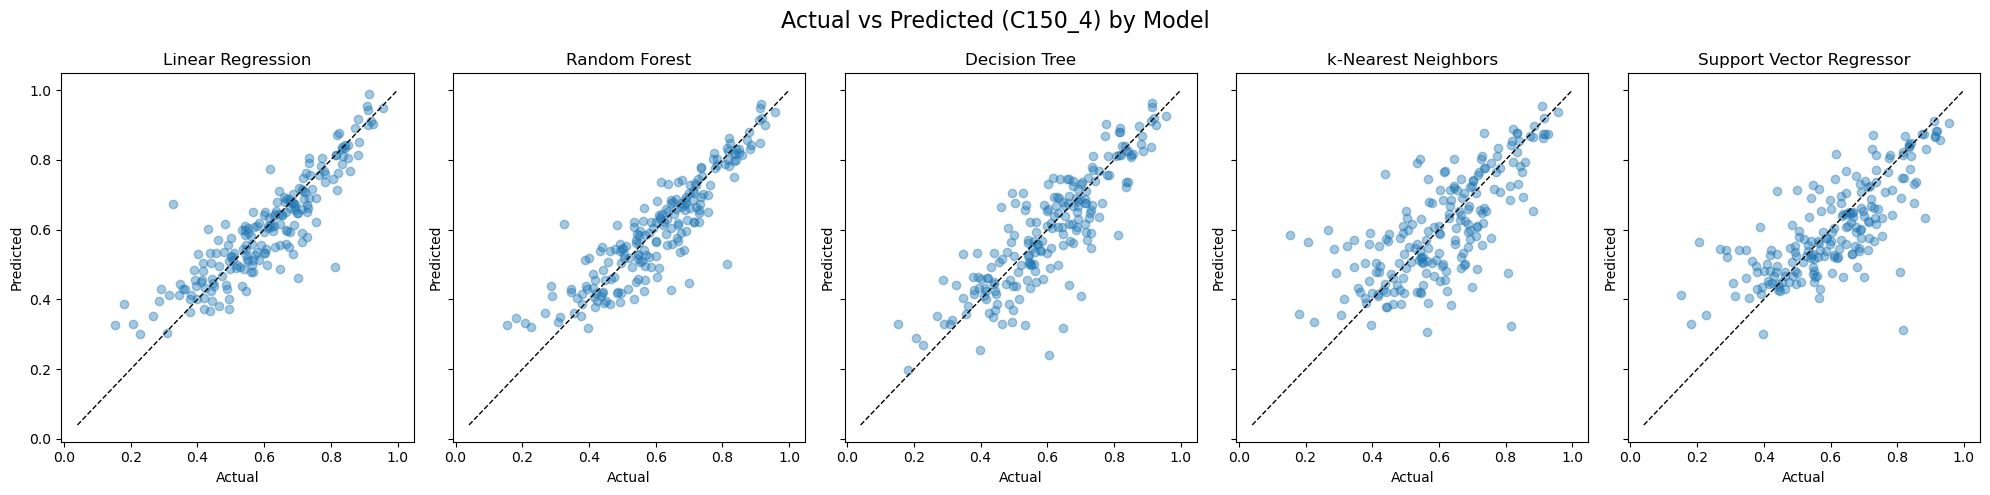

In [6]:
fig, axes = plt.subplots(1, len(fitted_models), figsize=(20, 5), sharex=True, sharey=True)

for ax, (name, model) in zip(axes, fitted_models.items()):
    y_pred = model.predict(X_test)

    ax.scatter(y_test, y_pred, alpha=0.4)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_title(name)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

fig.suptitle("Actual vs Predicted (C150_4) by Model", fontsize=16)
plt.tight_layout()
plt.show()


Step 7: Model Performance Comparison (R² Score)


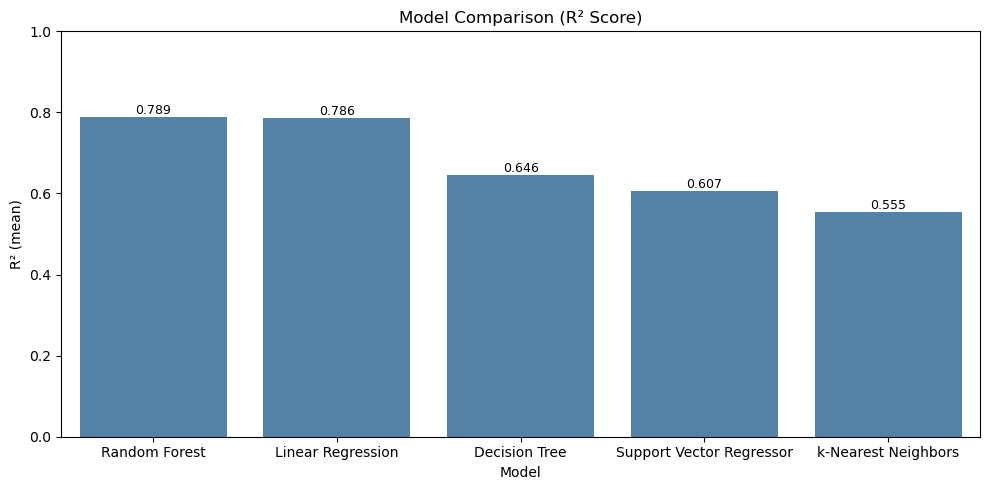

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=results_df, x='Model', y='R² (mean)', color='steelblue')
plt.title('Model Comparison (R² Score)')
plt.ylim(0, 1)

# Add text labels above each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Step 8: Model Performance Comparison (MSE Score)


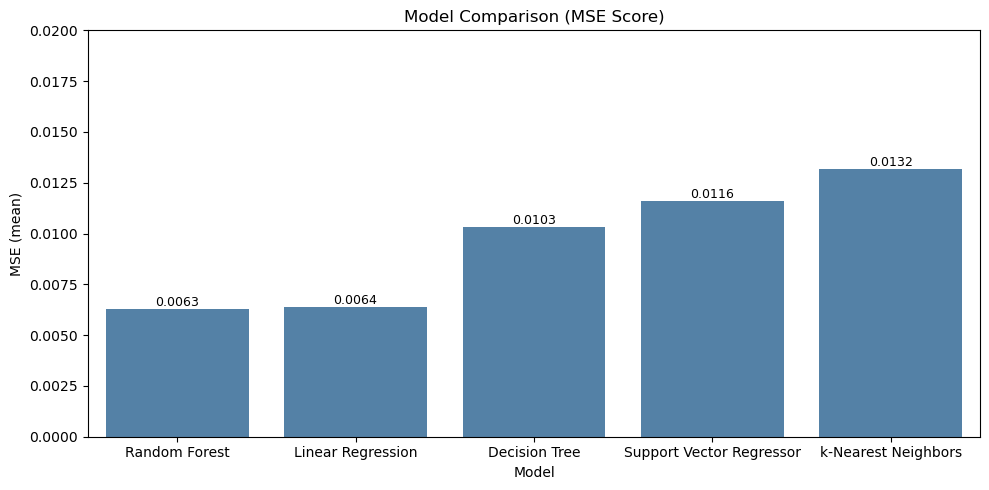

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=results_df, x='Model', y='MSE (mean)', color='steelblue')
plt.title('Model Comparison (MSE Score)')
plt.ylim(0, .02)

# Add text labels above each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Step 9: Residual Plots for all Models


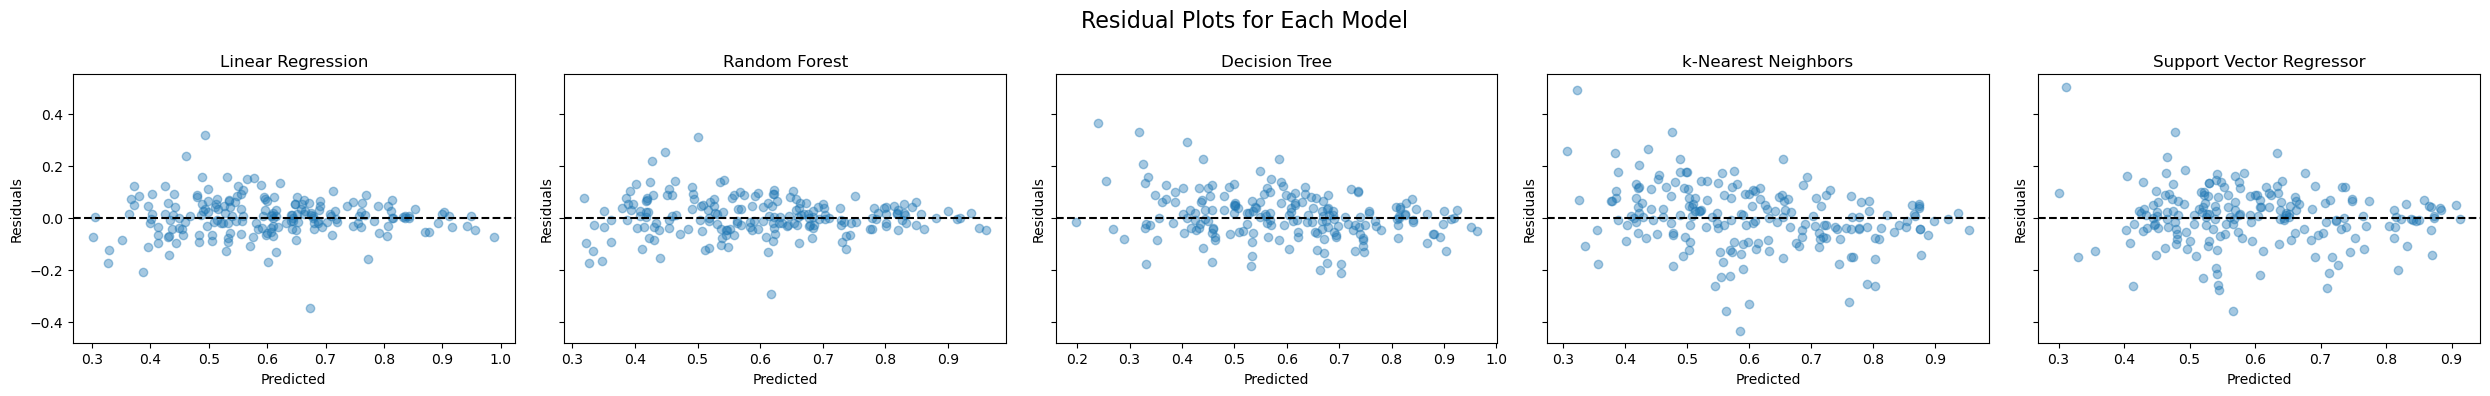

In [9]:
# Set up subplots
n_models = len(models)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4), sharey=True)

# Loop through models and plot residuals
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    ax.scatter(y_pred, residuals, alpha=0.4)
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")

fig.suptitle("Residual Plots for Each Model", fontsize=16)
plt.tight_layout()
plt.show()

Step 10: Interpretable Rules from Random Forest

We extracted the top-level rules from a single decision tree in our Random Forest to improve model interpretability. These rules reveal how certain thresholds in key features affect predicted graduation rates.

In [10]:
# Grab one tree from the Random Forest (e.g., first tree)
single_tree = fitted_models['Random Forest'].estimators_[0]

# Generate rules up to 3 levels deep
rf_rules = export_text(single_tree, feature_names=list(X.columns), max_depth=3)
print(rf_rules)

|--- RET_FT4 <= 0.82
|   |--- RET_FT4 <= 0.71
|   |   |--- RET_FT4 <= 0.63
|   |   |   |--- SAT_AVG <= 1005.00
|   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- SAT_AVG >  1005.00
|   |   |   |   |--- truncated branch of depth 12
|   |   |--- RET_FT4 >  0.63
|   |   |   |--- SAT_AVG <= 1019.50
|   |   |   |   |--- truncated branch of depth 9
|   |   |   |--- SAT_AVG >  1019.50
|   |   |   |   |--- truncated branch of depth 18
|   |--- RET_FT4 >  0.71
|   |   |--- TUITIONFEE_IN <= 35917.00
|   |   |   |--- SAT_AVG <= 1089.50
|   |   |   |   |--- truncated branch of depth 10
|   |   |   |--- SAT_AVG >  1089.50
|   |   |   |   |--- truncated branch of depth 19
|   |   |--- TUITIONFEE_IN >  35917.00
|   |   |   |--- RET_FT4 <= 0.79
|   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- RET_FT4 >  0.79
|   |   |   |   |--- truncated branch of depth 9
|--- RET_FT4 >  0.82
|   |--- RET_FT4 <= 0.88
|   |   |--- ACTCMMID <= 20.50
|   |   |   |--- value: [0.24]
|   | 

**Key Decision Paths:**

- If **Retention Rate (RET_FT4) ≤ 82%**:
  - And ≤ 71%:
    - And ≤ 63%:
      - If **SAT_AVG ≤ 1005**, predicted graduation rate is lower (depth 8)
      - If **SAT_AVG > 1005**, graduation rate improves (depth 12)
    - If between 63% and 71%:
      - Graduation rate is split again by **SAT_AVG ≈ 1020**
  - If RET_FT4 between **71%–82%**:
    - If **In-State Tuition ≤ $35,917** and **SAT_AVG ≤ 1090**, predicted rate is moderate
    - If **SAT_AVG > 1090**, performance increases

- If **Retention Rate > 82%**:
  - If **ACT Composite ≤ 20.5**, predicted graduation rate is low (≈ 24%)
  - If **ACT > 20.5** and **% of students over 25 > 42%**, predicted rate is very high (≈ 100%)

These decision rules confirm that retention rate and standardized test scores are strong indicators of 4-year graduation success, while tuition and age demographics provide meaningful interaction effects.
